# Feature engineering

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures

from darts import TimeSeries
from darts.utils.missing_values import extract_subseries

In [16]:
def holt_smoother(x: np.array, alpha: float) -> np.array:
    # https://empslocal.ex.ac.uk/people/staff/dbs202/cag/courses/MT37C/course/node102.html
    y = np.zeros_like(x)
    y[0] = x[0]

    for t in range(1, len(x)):
        y[t] = alpha * x[t] + (1 - alpha) * y[t - 1]

    return y


def generate_datetime_ts(ts: TimeSeries) -> TimeSeries:
    """Generates time series of date time features using one hot encoding"""
    dayofweek = (
        pd.get_dummies(ts.time_index.day_of_week)
        .rename(columns=lambda x: f"dow_{x}")
        .set_index(ts.time_index)
    )
    hours = (
        pd.get_dummies(ts.time_index.hour)
        .rename(columns=lambda x: f"hour_{x}")
        .set_index(ts.time_index)
    )

    datetime_features = dayofweek.merge(
        hours, left_index=True, right_index=True
    ).astype(int)

    return TimeSeries.from_dataframe(datetime_features)


def generate_poly_ts(ts: TimeSeries, degree: int) -> TimeSeries:
    poly_values = PolynomialFeatures(degree, include_bias=False).fit_transform(
        ts.values()
    )
    poly_features = pd.DataFrame(
        poly_values,
        columns=[f"feature_{i}" for i in range(poly_values.shape[1])],
        index=ts.time_index,
    )

    return TimeSeries.from_dataframe(
        poly_features,
        freq="h",
    )


def add_smoothed_precip(ts: TimeSeries, alpha: float):
    lp_precip = holt_smoother(ts["acc_precip"].values().ravel(), alpha)
    ts_lp = TimeSeries.from_series(
        pd.Series(lp_precip, index=ts.time_index, name="smooth_precip")
    )
    return ts.concatenate(ts_lp, axis=1)

In [17]:
%run data_split.ipynb
data: pd.DataFrame = data  # type: ignore # noqa: F821
train_mask: pd.Series = train_mask  # type: ignore # noqa: F821
test_mask: pd.Series = test_mask  # type: ignore # noqa: F821

- These variables have a big gap at the end, so we discard them

In [18]:
data.drop(columns=["temp_grass", "temp_soil_30"], inplace=True)

- We transform the target and precipitation by computing their logarithm. This step will _squeeze_ their values which can help during training.

In [19]:
data[["flow", "acc_precip"]] = data[["flow", "acc_precip"]].apply(np.log1p)

- Splitting between train and test based on this [notebook](./data_split.ipynb).

In [20]:
train_data = data[train_mask].copy()
test_data = data[test_mask].copy()

- For convenience, we use darts `TimeSeries` and extract continuous data chunks. Also, we discard periods that are too short.

In [ ]:
train_ts = TimeSeries.from_dataframe(train_data, freq="h")
subseries = extract_subseries(train_ts, mode="any")

min_length = 24 * 7  # 7 days
subseries = [s for s in subseries if len(s) >= min_length]

test_ts = TimeSeries.from_dataframe(test_data)

Total number of train samples 6961


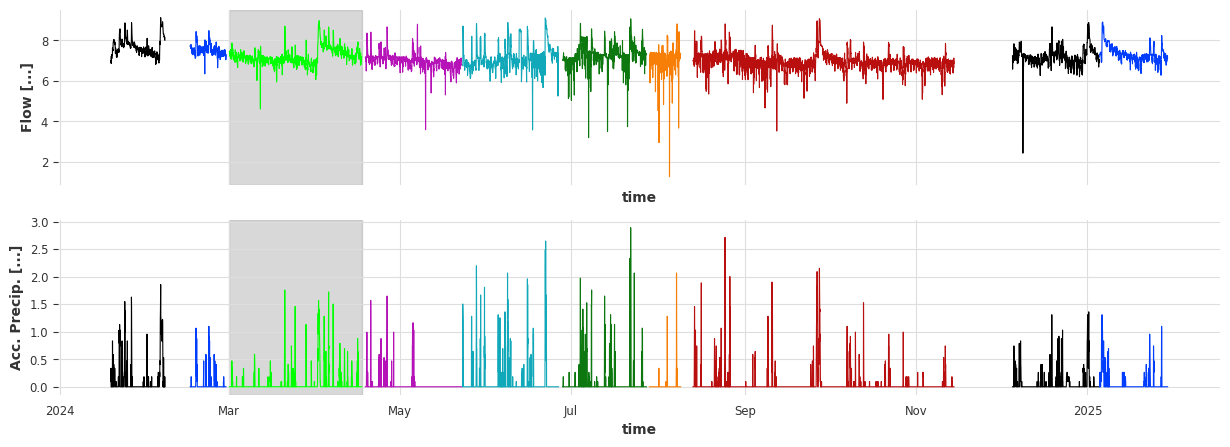

In [44]:
print(f"Total number of train samples {sum([len(s) for s in subseries])}")
fig, axes = plt.subplots(2, 1, figsize=(15, 5), sharex=True)
for s in subseries:
    s["flow"].plot(ax=axes[0], linewidth=0.8)
    s["acc_precip"].plot(ax=axes[1], linewidth=0.8)


test_ts["flow"].plot(linewidth=0.8, ax=axes[0], color="lime")
test_ts["acc_precip"].plot(linewidth=0.8, ax=axes[1], color="lime")

axes[0].axvspan(test_ts.time_index[0], test_ts.time_index[-1], color="grey", alpha=0.3)
axes[1].axvspan(test_ts.time_index[0], test_ts.time_index[-1], color="grey", alpha=0.3)

axes[0].legend().set_visible(False), axes[1].legend().set_visible(False)
axes[0].set_ylabel("Flow [...]"), axes[1].set_ylabel("Acc. Precip. [...]");

- Splitting between target and covariates

In [ ]:
target_subseries = [s["flow"] for s in subseries]
covariates_subseries = [s.drop_columns("flow") for s in subseries]

test_target = test_ts["flow"]
test_covariates = test_ts.drop_columns("flow")

- We include a smoothed rain
    - The dynamics of observed precipitation are faster than their effects. We smooth the precipitation by using a Holt exponential smoother; the value of the parameter $\alpha$ is chosen based on the correlation study in the overview [notebook](./overview.ipynb).
- We include polynomial functions of the weather features
- We include datetime features, using one hot encoding

In [ ]:
alpha = 0.2  # smoothing coefficient
deg = 3  # polynomial degree

expanded_covariates = []
for s in covariates_subseries:
    s = add_smoothed_precip(s, alpha)
    s1 = generate_poly_ts(s, deg)
    s2 = generate_datetime_ts(s)

    expanded_covariates.append(s1.concatenate(s2, axis=1))


test_covariates = add_smoothed_precip(test_covariates, alpha)
tc1 = generate_poly_ts(test_covariates, deg)
tc2 = generate_datetime_ts(test_covariates)

test_covariates = tc1.concatenate(tc2, axis=1)